In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import yaml
from scipy.stats import spearmanr
from sklearn.metrics import precision_recall_curve, roc_curve, average_precision_score, roc_auc_score
from os.path import join

%matplotlib inline

In [2]:
perp_fp_fmt = '../simulated-lung-data/output/lung-simulated/perplexity_lgt/{sample}/vbprior={vb_prior}/{fold}/perplexity.yml'
pred_tpm_fmt = '../simulated-lung-data/output/lung-simulated/quants/{sample}/vbprior={vb_prior}/{fold}/quant.sf'
de_results_fmt = '../simulated-lung-data/output/lung-simulated/de/vbprior={vbprior}/k={k}_swish_results.tsv'

lung_data_dir = '/fs/cbcb-lab/rob/students/jason/perplexity-wabi-backup/lung-simulated-data/'
true_tpm_fmt = join(lung_data_dir, 'ground_truths/{sample}.sf')
down_reg_txs_path = join(lung_data_dir, 'ground_truths/down.txt')
up_reg_txs_path = join(lung_data_dir, 'ground_truths/up.txt')

In [3]:
SAMPLES = [
    'SRR1265495',
    'SRR1265496',
    'SRR1265497',
    'SRR1265498',
    'SRR1265499',
    'SRR1265500',
    'SRR1265501',
    'SRR1265502',
    'SRR1265503',
    'SRR1265504',]
VB_PRIORS = '1e-2 1 2 3 4 5 6 7 8 9 10'.split()

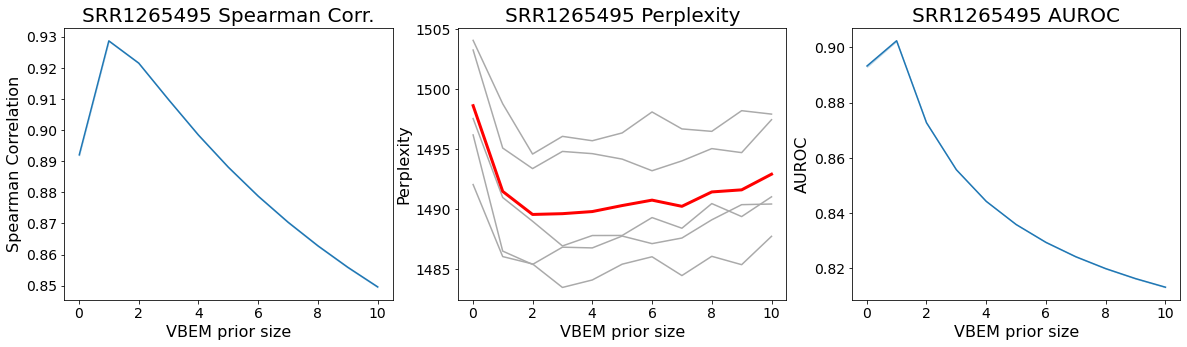

In [4]:
def mask_zero_corr_plot(sample, vb_priors, folds):
    true_tpm_fp = true_tpm_fmt.format(sample=sample)
    true_tpm = pd.read_csv(true_tpm_fp, sep='\t').TPM.values

    mask = true_tpm > 0
    df = pd.DataFrame()
    for vb_prior in vb_priors:
        #folds_rhos = []
        for fold in range(1, folds + 1):
            with open(perp_fp_fmt.format(sample=sample, vb_prior=vb_prior, fold=fold), 'r') as f:
                perp_result = yaml.safe_load(f)
            pred_tpm_fp = pred_tpm_fmt.format(sample=sample, fold=fold, vb_prior=vb_prior)

            pred_tpm = pd.read_csv(pred_tpm_fp, sep='\t').TPM.values
            true_tpm_masked = true_tpm[mask]
            pred_tpm_masked = pred_tpm[mask]
            
            rho, p = spearmanr(true_tpm_masked, pred_tpm_masked)
            auroc = roc_auc_score(true_tpm == 0 , -pred_tpm)
            _vb_prior = float(vb_prior)
            df = df.append(dict(spearman = rho,
                                auroc=auroc,
                                perplexity=perp_result['smoothed_perplexity'],
                                vb_prior=_vb_prior, log_vb_prior = np.log10(_vb_prior),
                                fold=fold), 
                           ignore_index=True)
    
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    title_fs=20
    ax_fs=16
    ax[0].set_title(sample + " Spearman Corr.", fontsize=title_fs)
    ax[0].set_ylabel('Spearman Correlation', fontsize=ax_fs)
    ax[1].set_title(sample + " Perplexity", fontsize=title_fs)
    ax[1].set_ylabel('Perplexity', fontsize=ax_fs)
    ax[2].set_title(sample + " AUROC", fontsize=title_fs)
    ax[2].set_ylabel('AUROC', fontsize=ax_fs)
    
    for a in ax:
        a.set_xlabel('VBEM prior size', fontsize=ax_fs)
        a.tick_params(axis='both', which='major', labelsize=14)

    
    sns.lineplot(x="vb_prior", y="spearman", data=df, ax=ax[0])
    sns.lineplot(x="vb_prior", y="perplexity", data=df, ax=ax[1], units="fold", estimator=None, color='#AAAAAA')
    sns.lineplot(x="vb_prior", y="perplexity", data=df, ax=ax[1], err_style=None, lw=3, color="red")
    sns.lineplot(x="vb_prior", y="auroc", data=df, ax=ax[2])

    plt.show()
    
    
    return ax
df = mask_zero_corr_plot('SRR1265495', VB_PRIORS, 5)


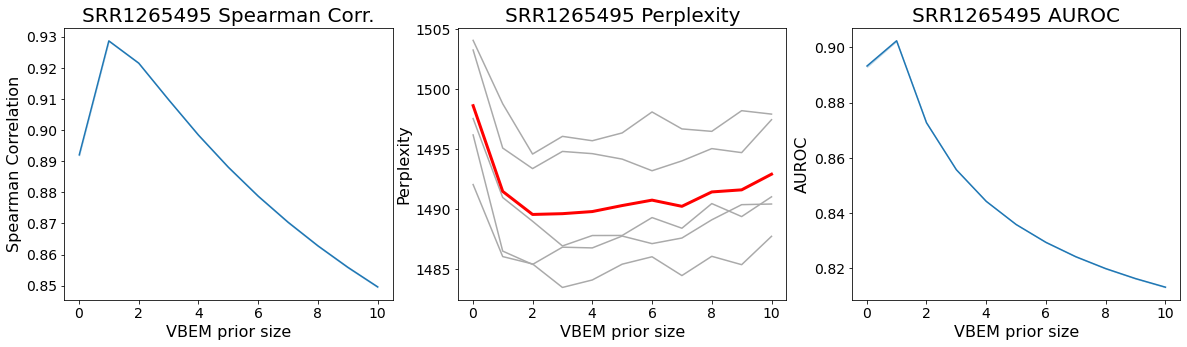

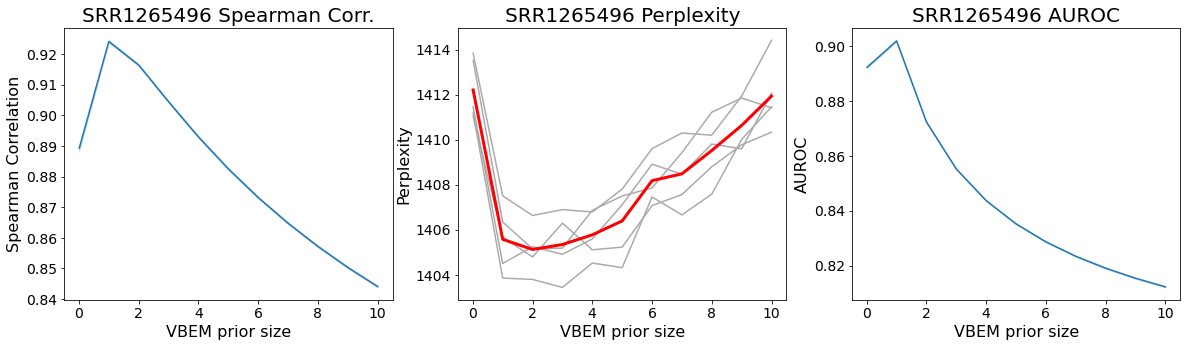

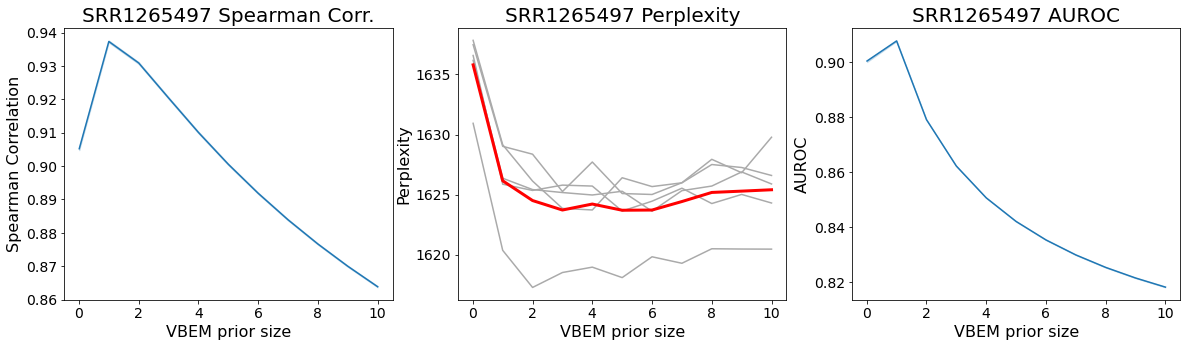

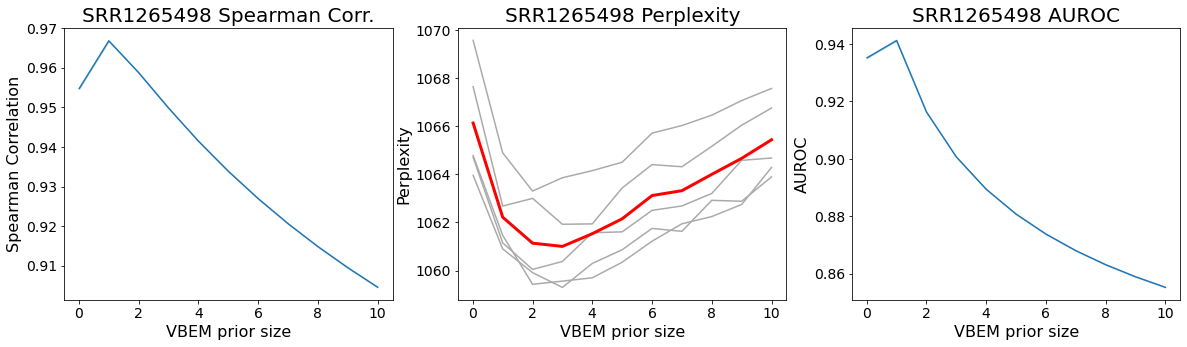

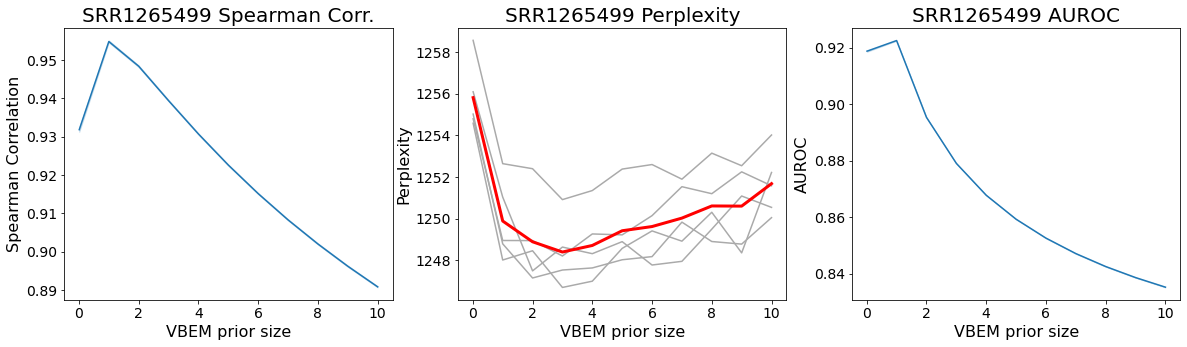

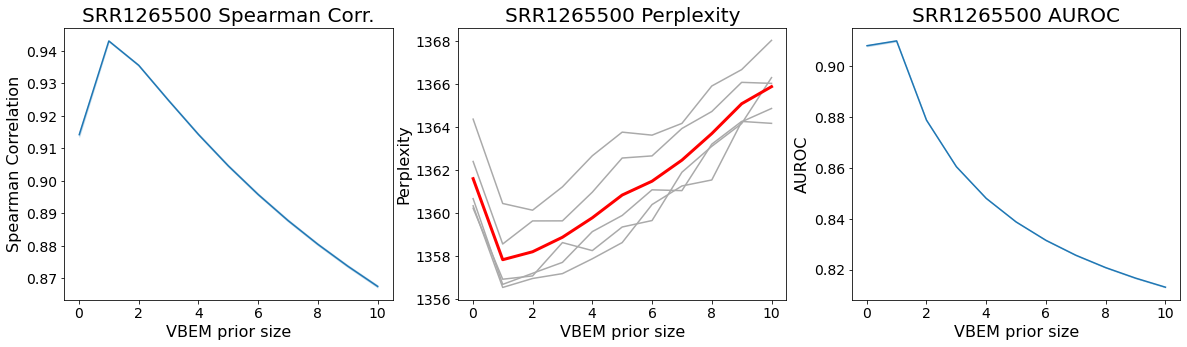

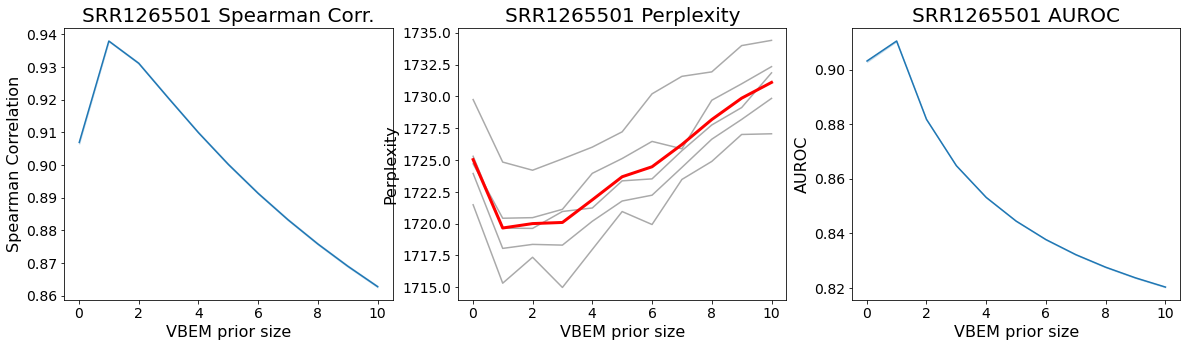

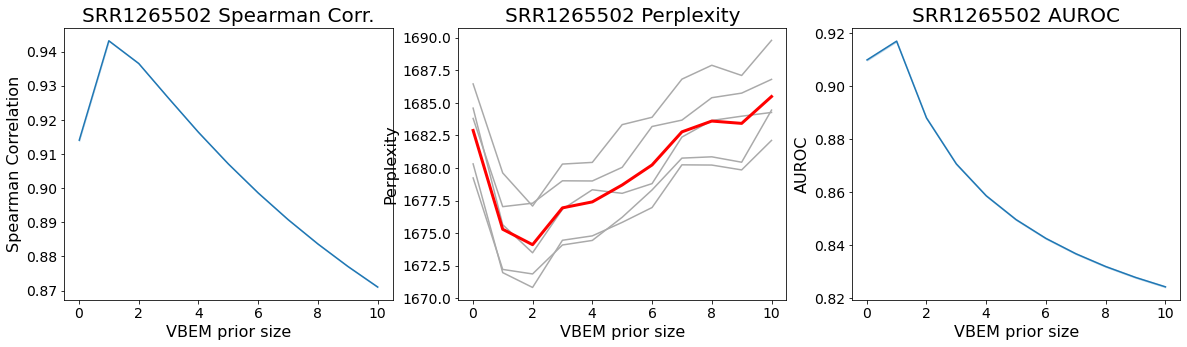

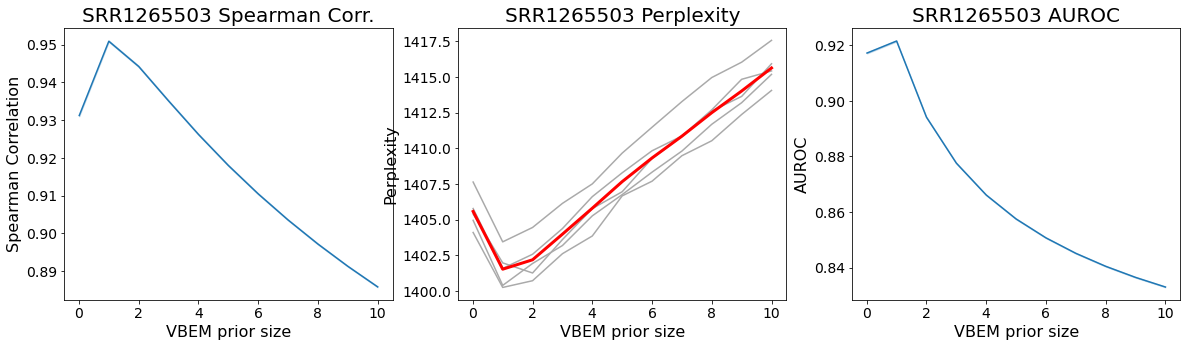

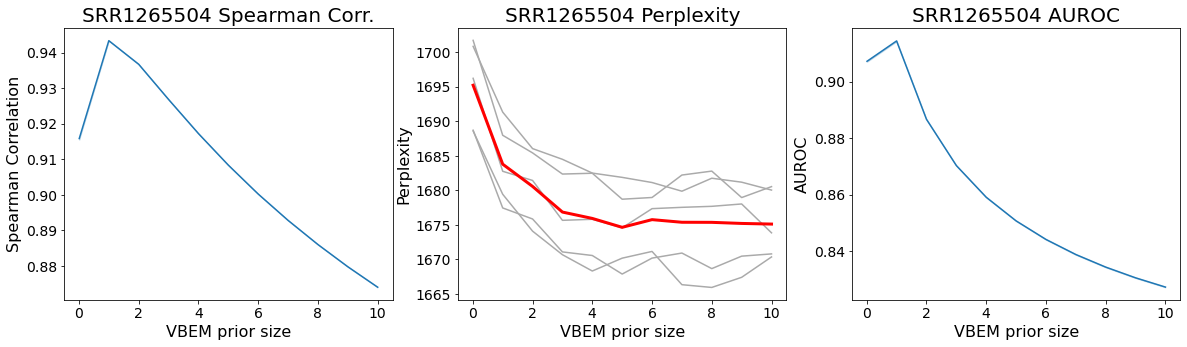

In [5]:
for sample in SAMPLES:
    df = mask_zero_corr_plot(sample, VB_PRIORS, 5)

## DE results

Note: Some pre-processing is required. Provided 'up/down' regulated txs in `{up, down}.tsv` are simply sampled from the reference and may not be expressed in at least one sample. We pre-process and only say that a tx is DE if it is expressed in at least one sample in `SRR...495-499`.

In [6]:
down_reg_txs = pd.read_csv(down_reg_txs_path, header=None)[0].values
up_reg_txs = pd.read_csv(up_reg_txs_path, header=None)[0].values

In [7]:
# pd.read_csv(de_results_fmt.format(vbprior='1', k=1), sep='\t')

In [8]:
# An example of an abundance estimate in salmon format
sf_fp = true_tpm_fmt.format(sample='SRR1265504')
sf_df = pd.read_csv(sf_fp, sep='\t').set_index('Name')
sf_df

,Length,EffectiveLength,TPM,NumReads
Name,,,,
ENST00000415118.1,8,8.0,0.0,0.0
ENST00000434970.2,9,9.0,0.0,0.0
ENST00000448914.1,13,13.0,0.0,0.0
ENST00000604642.1,23,23.0,0.0,0.0
ENST00000603326.1,19,19.0,0.0,0.0
...,...,...,...,...
ENST00000504127.1,63,63.0,0.0,0.0
ENST00000390522.1,62,62.0,0.0,0.0
ENST00000436826.1,50,50.0,0.0,0.0


In [9]:
# df = pd.read_csv(de_results_fmt.format(vbprior=VB_PRIORS[0], k=1), sep='\t')
# df.index = df.index.rename('Name')
# df

In [10]:
fc_txs = set(down_reg_txs) | set(up_reg_txs)

txs = set()

is_expressed = np.zeros(len(sf_df.index.values), dtype=bool)
for s in SAMPLES:
    tpms_df = pd.read_csv(true_tpm_fmt.format(sample=s), sep='\t')
    is_expressed |= tpms_df['NumReads'].values > 0


In [11]:
is_expressed.sum() / len(is_expressed)

0.7969665447066983

In [12]:
expressed_txs = set(sf_df.index.values[is_expressed])
fc_txs = set(down_reg_txs) | set(up_reg_txs)
print(len(fc_txs))
fc_txs = fc_txs & expressed_txs
print(len(fc_txs))

16726
13269


In [13]:
def roc_score(vbprior, ks, max_fpr=1):
    scores = []
    for k in range(1, ks+1):
        res_df = pd.read_csv(de_results_fmt.format(vbprior=vbprior, k=k), sep='\t')
        res_df.index = res_df.index.rename('Name')
        res_df.qvalue = res_df.qvalue.fillna(1.)
        res_df.pvalue = res_df.pvalue.fillna(1.)
        res_df['label'] = res_df.index.isin(fc_txs)
        score = roc_auc_score(res_df['label'], -res_df.qvalue, max_fpr=max_fpr)
        scores.append(score)
#         plt.plot((res_df['label'], -res_df.padj))
        
    return np.mean(score)

def roc_score_fold(vbprior, fold, max_fpr=1):
    res_df = pd.read_csv(de_results_fmt.format(vbprior=vbprior, k=fold), sep='\t')
    res_df.index = res_df.index.rename('Name')
    res_df.qvalue = res_df.qvalue.fillna(1.)
    res_df.pvalue = res_df.pvalue.fillna(1.)
    res_df['label'] = res_df.index.isin(fc_txs)
    score = roc_auc_score(res_df['label'], -res_df.qvalue, max_fpr=max_fpr)
    return score

# de_res = pd.DataFrame()
# for vbprior in VB_PRIORS:
#     roc=roc_score(vbprior,5)
#     de_res= de_res.append(dict(vb_prior=vbprior, AUROC=roc), ignore_index=True)
roc_score_fold(VB_PRIORS[0], fold=5)

0.5769153825928669

In [14]:
de_res = pd.DataFrame()
for max_fpr in [0.01, 0.05, 0.1, 0.2, 1.0]:
    for fold in range(1, 6):
        for vbprior in VB_PRIORS:
            de_res = de_res.append(dict(vb_prior=vbprior, 
                                        AUROC=roc_score_fold(vbprior, fold, max_fpr=max_fpr),
                                        max_fpr=max_fpr), 
                                   ignore_index=True)

In [15]:
de_res

,AUROC,max_fpr,vb_prior
0,0.543026,0.01,1e-2
1,0.544658,0.01,1
2,0.543745,0.01,2
3,0.542542,0.01,3
4,0.541465,0.01,4
...,...,...,...
270,0.587244,1.00,6
271,0.587478,1.00,7
272,0.587662,1.00,8
273,0.587241,1.00,9


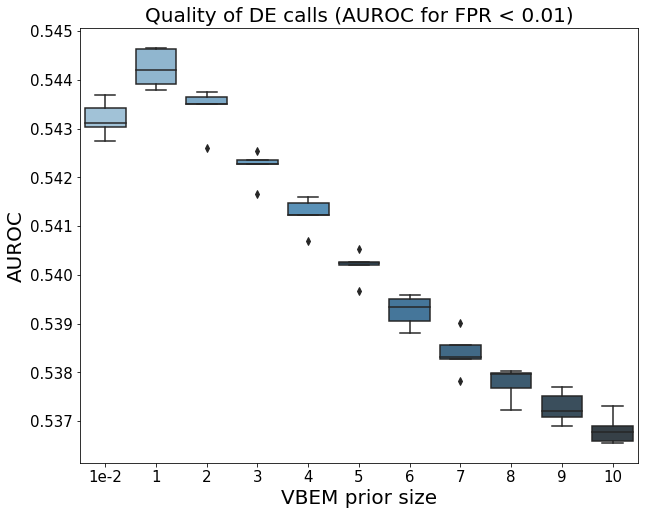

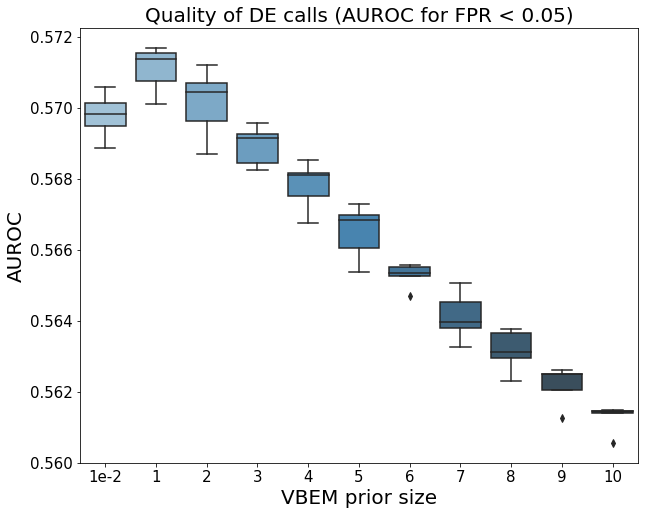

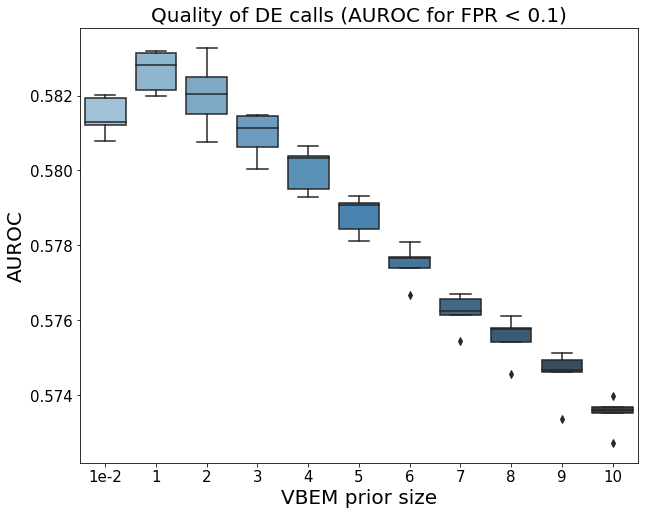

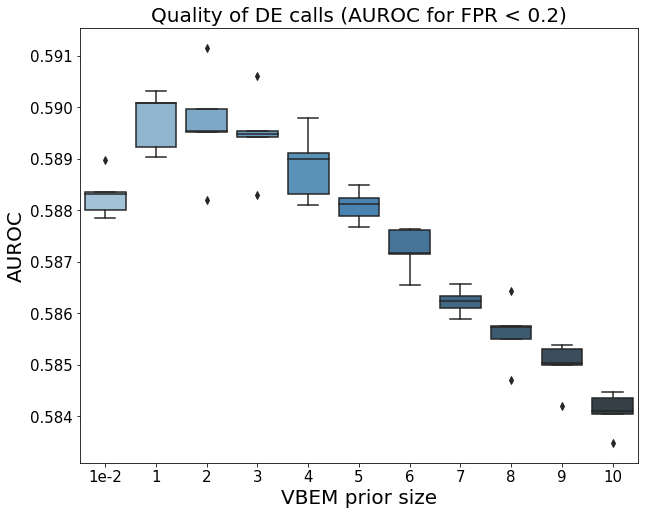

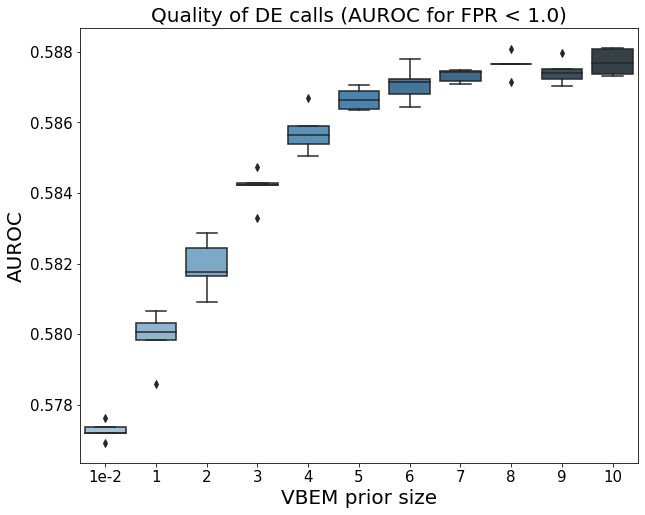

In [16]:
for max_fpr in [0.01, 0.05, 0.1, 0.2, 1.0]:
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax = sns.boxplot(data=de_res[de_res.max_fpr == max_fpr], y="AUROC", x='vb_prior', palette="Blues_d")
    ax.set_title("Quality of DE calls (AUROC for FPR < {})".format(str(max_fpr)), fontsize=20)
    
    ax.set_ylabel('AUROC', fontsize=20)
    ax.set_xlabel('VBEM prior size', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.show()

In [17]:
def plot_roc(vbprior, k, ax, fpr_thresh=1, **kwargs):
    res_df = pd.read_csv(de_results_fmt.format(vbprior=vbprior, k=k), sep='\t')
    res_df.index = res_df.index.rename('Name')
    res_df.qvalue = res_df.qvalue.fillna(1.)
    res_df.pvalue = res_df.pvalue.fillna(1.)
    res_df['label'] = res_df.index.isin(fc_txs)
    res_df['label'] = res_df.index.isin(fc_txs)

    fpr, tpr, _ = roc_curve(res_df['label'], -res_df.qvalue) 
    flags = fpr < fpr_thresh
    fpr = fpr[flags]
    tpr = tpr[flags]
    ax.set_title('ROC curves for DE calls', fontsize=20)
    ax.set_xlabel('FPR', fontsize=20)
    ax.set_ylabel('TPR', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.plot(fpr, tpr, label=float(vbprior), **kwargs)

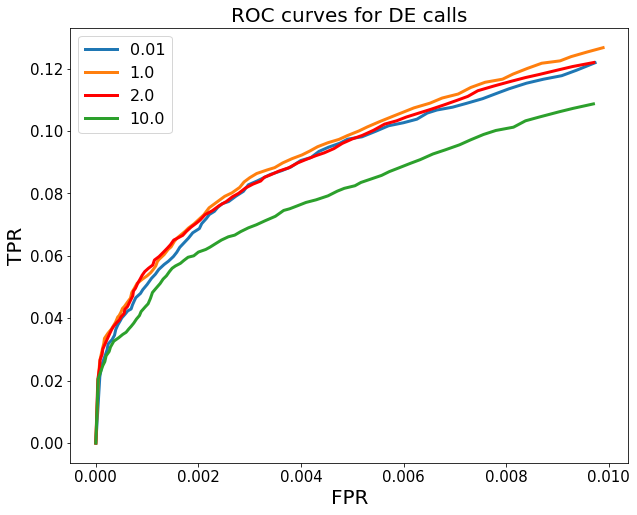

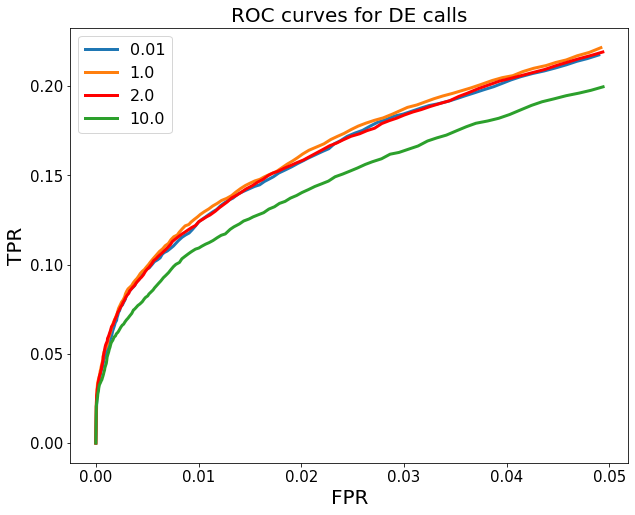

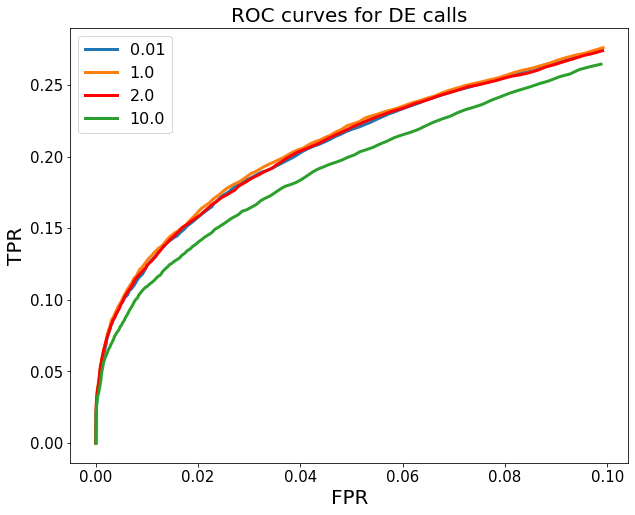

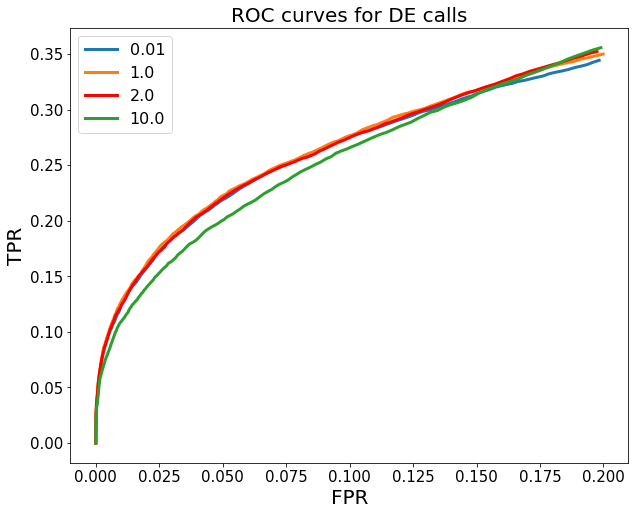

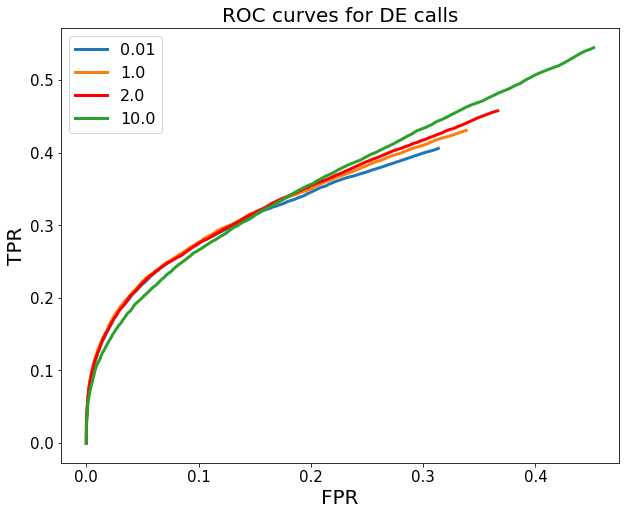

In [18]:
plt.rcParams['image.cmap'] = 'inferno'

for t in [0.01, 0.05, 0.1, 0.2, 1]:
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    for vbprior in '1e-2 1 2 10'.split():
        if vbprior == '2':
            plot_roc(vbprior, 1, ax, fpr_thresh=t, c='red', lw=3, )
        else:
            plot_roc(vbprior, 1, ax, fpr_thresh=t,  lw=3,)
    plt.legend(fontsize=16)
    plt.show()

